# Detect Anomalies Using Density Based Clustering


## Clustering-Based Anomaly Detection

- Assumption: Data points that are similar tend to belong to similar groups or clusters, as determined by their distance from local centroids. Normal data points occur around a dense neighborhood and abnormalities are far away.

- Using density based clustering, like DBSCAN, we can design the model such that the data points that do not fall into a cluster are the anomalies.


In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# DBSCAN import
from sklearn.cluster import DBSCAN
# Scaler import
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Import .txt file and convert it to a DataFrame object
df = pd.read_table("curriculum-access.txt", sep = '\s', header = None, 
                   names = ['date', 'time', 'page', 'id', 'cohort', 'ip'])


In [3]:
df.head()

,date,time,page,id,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


Questions about this data:

What does the interaction with the pages look like on a user by user basis?

What does the interaction with the pages look like on a cohort by cohort basis?

In [7]:
id_counts = df.groupby('id')[['page','date','cohort']].nunique()

In [8]:
cohort_counts = df.groupby('cohort')[['page','date','id']].nunique()

In [13]:
# df.info()

In [11]:
cohort_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, 1.0 to 139.0
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   page    47 non-null     int64
 1   date    47 non-null     int64
 2   id      47 non-null     int64
dtypes: int64(3)
memory usage: 1.5 KB


In [14]:
cohort_counts.head()

,page,date,id
cohort,,,
1.0,342,278,18
2.0,44,12,3
4.0,4,1,1
5.0,1,1,1
6.0,45,12,2


<Axes: >

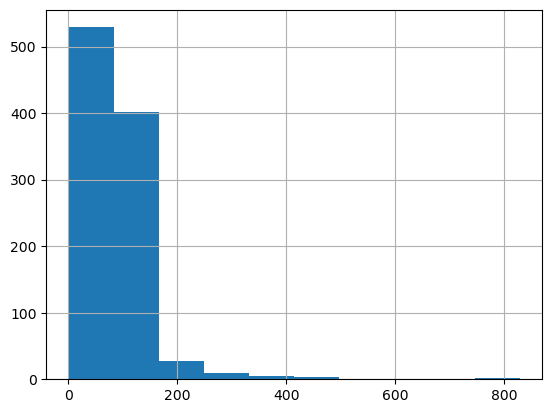

In [15]:
id_counts.date.hist()

Takeaways from these aggregates and visualizations so far:
 - We would anticipate a unique number of days where curriculum was accessed on a user by user basis to hover around the number of days the student was in the program, more or less.  I would be interested in exceptionally low or exceptionally high instances

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    900223 non-null  object 
 1   time    900223 non-null  object 
 2   page    900222 non-null  object 
 3   id      900223 non-null  int64  
 4   cohort  847330 non-null  float64
 5   ip      900223 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 41.2+ MB


In [ ]:
# we want to make sure that our date is converted into a datetime object if we
# want to do date math on it :)


In [18]:
df['date'] = pd.to_datetime(df['date'])
first_access = df.groupby('id').date.min()

In [19]:
first_access

id
1     2018-01-26
2     2018-01-26
3     2018-01-26
4     2018-01-26
5     2018-01-26
         ...    
977   2021-04-12
978   2021-04-12
979   2021-04-12
980   2021-04-13
981   2021-04-19
Name: date, Length: 981, dtype: datetime64[ns]

In [20]:
first_access_date = pd.DataFrame({'first_access_date': first_access}).reset_index()

In [21]:
first_access_date

,id,first_access_date
0,1,2018-01-26
1,2,2018-01-26
2,3,2018-01-26
3,4,2018-01-26
4,5,2018-01-26
...,...,...
976,977,2021-04-12
977,978,2021-04-12
978,979,2021-04-12
979,980,2021-04-13


In [25]:
id_by_first_access_date = first_access_date.groupby(['first_access_date']).count()

In [27]:
id_by_first_access_date.head()

,id
first_access_date,
2018-01-26,50
2018-01-27,2
2018-01-28,2
2018-01-29,12
2018-01-30,7


Text(0.5, 1.0, 'Number of First Access Counts Over Time')

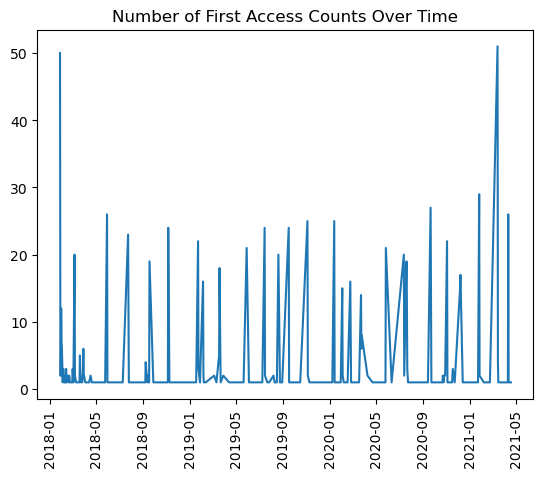

In [28]:
plt.plot(id_by_first_access_date)
plt.xticks(rotation=90)
plt.title('Number of First Access Counts Over Time')

Takeaways:
 - There appears to be a pretty distinct pattern of individuals all starting to access the curriculum on starting dates.
 - If we sort these a little more, we could likely see where these cohorts began

### Further questions from this point:
 - Based on this initial information regarding how we see behavior for individuals on a id-by-id and a cohort-by-cohort basis, can we examine what potentially scraping or content-ripping behavior looks like?
 
 - To investigate our question, let's take a look at users and their number of unique pages accessed in comparison to the number of total pages that they accessed.  We might surmise that someone that only visits a page once ever is not the same type of user as a student, who is likely going back to the content, and probably at a similar ratio to their peers

In [30]:
# grab the page count, grab the unique page access (per user)
page_views = df.groupby(['id'])['page'].agg(['count','nunique'])

<Axes: >

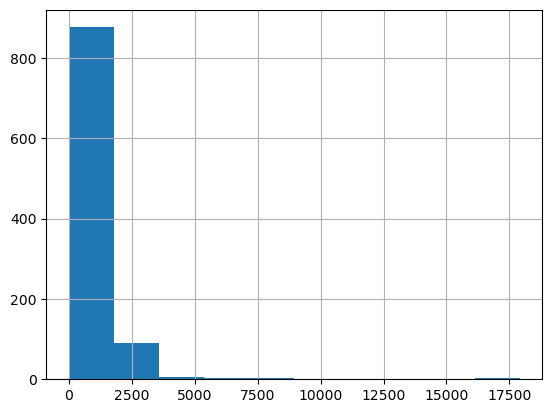

In [32]:
page_views['count'].hist()

In [34]:
# an exceptionally low visit count is likely between 250 and 600

<Axes: >

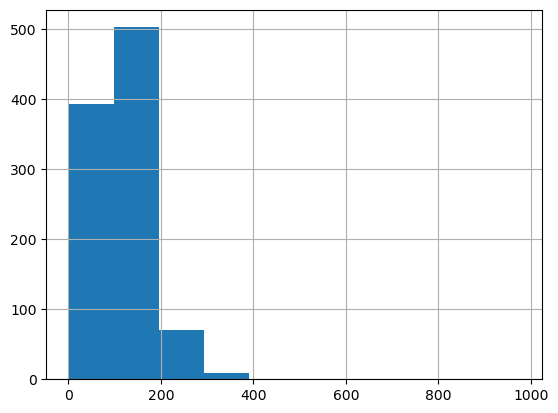

In [33]:
page_views['nunique'].hist()

In [35]:
page_views[(page_views['count'] < 600) & (page_views['nunique'] > 190)]

,count,nunique
id,,
51,592,194
313,270,194


### Let's examine these count and page view ratios in a way where we map them via clustering

In [36]:
#note: i'm using clustering for anomaly detection, finding information on historical
# data.  I'm not trying to project outward patterns or trends, 
# and i'm not trying to hold assertions about production data.
# this means its ok to do this without a data split.
# make and fit the thing
scaler = MinMaxScaler().fit(page_views)
# use the thing
scaled_pages = scaler.transform(page_views)

In [37]:
scaled_pages

array([[4.13298347e-01, 1.00000000e+00],
       [8.59758821e-02, 1.53846154e-01],
       [8.71482805e-02, 1.72307692e-01],
       ...,
       [7.03439035e-03, 1.94871795e-02],
       [1.11656990e-04, 0.00000000e+00],
       [2.28896829e-03, 8.20512821e-03]])

In [40]:
# reassign scaled pages into a dataframe
# give it the same index basis as we had previously (so we know which id)
# give it a version of the column names where its scaled
scaled_pages = pd.DataFrame(scaled_pages, 
             columns=[i+'_scaled' for i in page_views.columns], 
             index=page_views.index)

In [42]:
pd.concat([page_views, scaled_pages], axis=1).head()

,count,nunique,count_scaled,nunique_scaled
id,,,,
1,7404,976,0.413298,1.000000
2,1541,151,0.085976,0.153846
3,1562,169,0.087148,0.172308
4,692,143,0.038577,0.145641
5,1701,197,0.094908,0.201026


Making my DBSCAN object and fitting it to my data:

In [45]:
page_views.shape

(981, 2)

In [43]:
# make the thing
d_clusts = DBSCAN(eps=0.1, min_samples=15)

In [44]:
# fit the thing
d_clusts.fit(scaled_pages)

DBSCAN(eps=0.1, min_samples=15)

In [46]:
# how get useful info?

In [48]:
page_views['cluster_assigned'] = d_clusts.labels_

In [49]:
page_views.head()

,count,nunique,cluster_assigned
id,,,
1,7404,976,-1
2,1541,151,0
3,1562,169,0
4,692,143,0
5,1701,197,0


In [50]:
page_views.cluster_assigned.value_counts()

cluster_assigned
 0    973
-1      8
Name: count, dtype: int64

It looks like theres only one cluster based on our parameters. neat!

Theres also more than two samples than when we were examining these metrics by eyeballing those 600 and 150-ish stats

In [51]:
page_views[page_views.cluster_assigned != 0]

,count,nunique,cluster_assigned
id,,,
1,7404,976,-1
11,17913,871,-1
53,12329,333,-1
64,16347,437,-1
248,5075,625,-1
314,7783,225,-1
495,6451,243,-1
581,6434,354,-1


In [53]:
scaled_pages['cluster_assigned'] = d_clusts.labels_

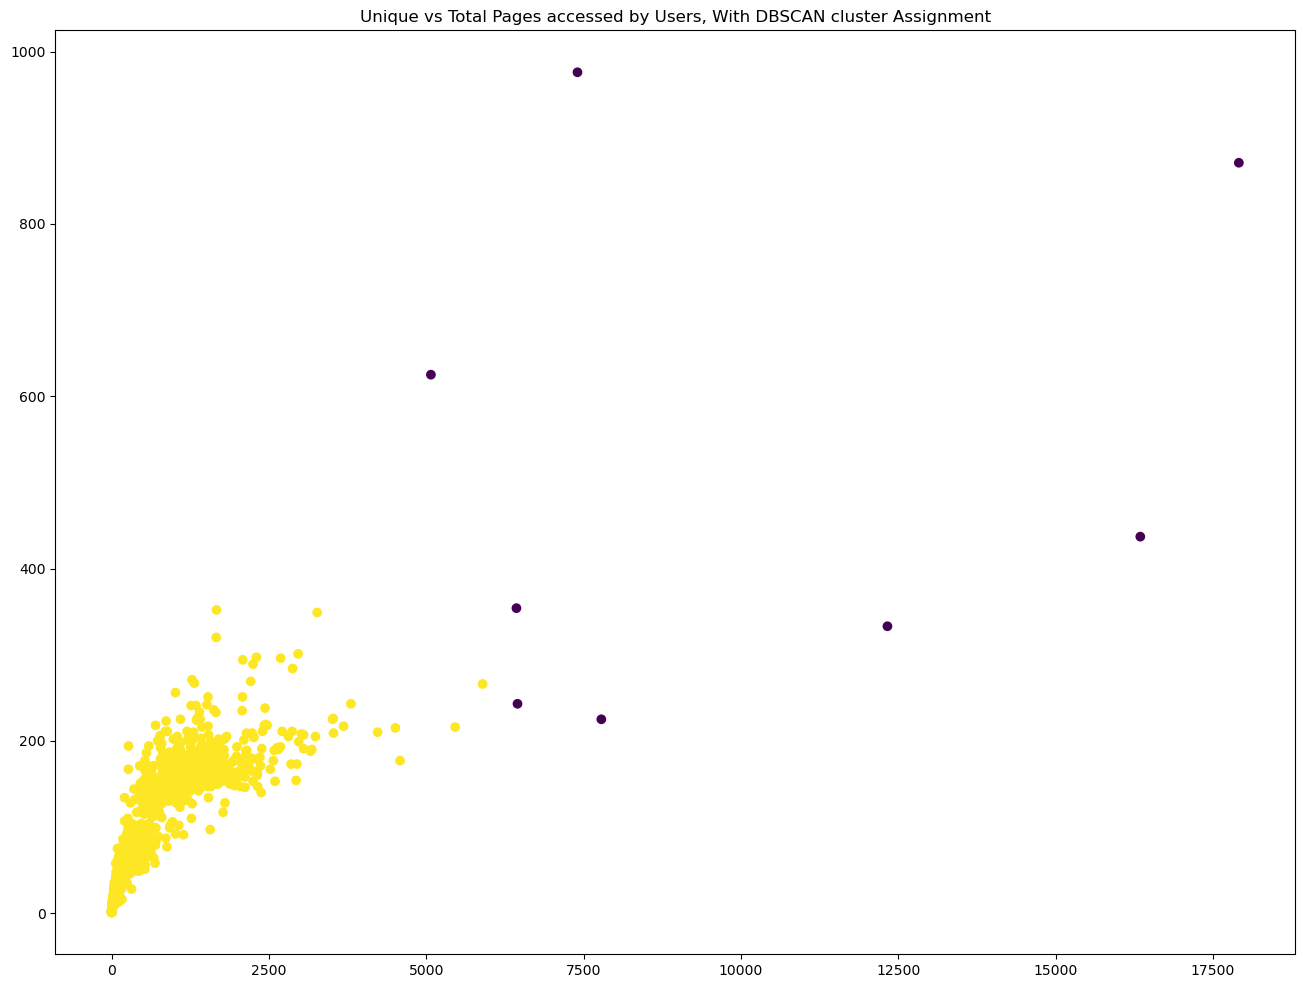

In [52]:
plt.figure(figsize=(16,12))
plt.scatter(page_views['count'],
            page_views['nunique'],
            c=page_views['cluster_assigned'])
plt.title('Unique vs Total Pages accessed by Users, With DBSCAN cluster Assignment')
plt.show()

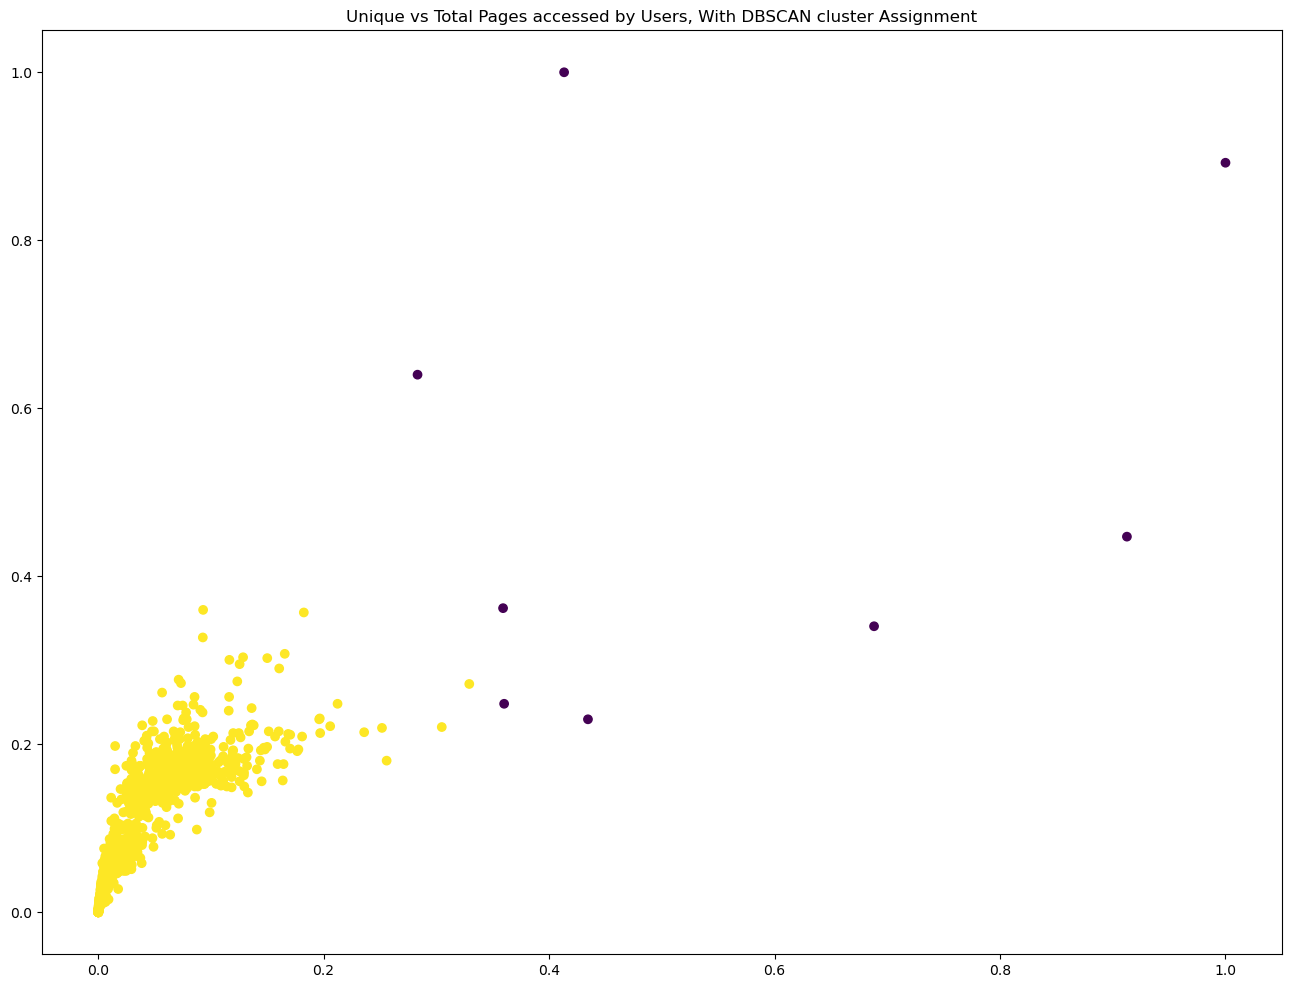

In [55]:
plt.figure(figsize=(16,12))
plt.scatter(scaled_pages['count_scaled'],
            scaled_pages['nunique_scaled'],
            c=scaled_pages['cluster_assigned'])
plt.title('Unique vs Total Pages accessed by Users, With DBSCAN cluster Assignment')
plt.show()